# Introduction and problem statement

Information online has been increasing at an exponential rate and the issue of information overload has become increasingly prevalent. In the context of the movie industry, there are a plethora of options for one to choose from and simply searching for a specific genre may no longer be effective in finding an effective recommendation. 

Hence we propose a content-based recommendation system to give precise recommendations efficiently. 

## Data preparation and cleaning 

In [1]:
# Importing Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ast
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df1 = pd.read_csv('tmdb_5000_movies.csv')
df2 = pd.read_csv('tmdb_5000_credits.csv')
df2.rename(columns = {'title':'titledupe'}, inplace = True) 

In [3]:
rawmoviesdf = pd.concat([df1,df2], axis=1)

In [4]:
print(rawmoviesdf.shape)

(4803, 24)


In [5]:
rawmoviesdf.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,titledupe,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [6]:
rawmoviesdf.isnull().sum()

budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                  844
title                      0
vote_average               0
vote_count                 0
movie_id                   0
titledupe                  0
cast                       0
crew                       0
dtype: int64

In [7]:
# Deemed columns such as genres, keywords, crew (director), cast (lead actors) as important features for a recommendation system
# Dropped the rest of the columns

to_drop = ['budget','homepage','original_language','original_title','overview','production_companies','production_countries','release_date','revenue','runtime','spoken_languages','status','titledupe']
rawmoviesdf.drop(to_drop, inplace=True, axis=1) 

In [8]:
rawmoviesdf.head(2)

,genres,id,keywords,popularity,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",150.437577,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",139.082615,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [9]:
rawmoviesdf.describe()

,id,popularity,vote_average,vote_count,movie_id
count,4803.000000,4803.000000,4803.000000,4803.000000,4803.000000
mean,57165.484281,21.492301,6.092172,690.217989,57165.484281
std,88694.614033,31.816650,1.194612,1234.585891,88694.614033
min,5.000000,0.000000,0.000000,0.000000,5.000000
25%,9014.500000,4.668070,5.600000,54.000000,9014.500000
50%,14629.000000,12.921594,6.200000,235.000000,14629.000000
75%,58610.500000,28.313505,6.800000,737.000000,58610.500000
max,459488.000000,875.581305,10.000000,13752.000000,459488.000000


In [10]:
rawmoviesdf.drop_duplicates(inplace = True)

In [11]:
print("Data type : ", type(rawmoviesdf))
print("Data dims : ", rawmoviesdf.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (4803, 11)


In [12]:
rawmoviesdf[['popularity','vote_average','vote_count']].isnull().sum()

popularity      0
vote_average    0
vote_count      0
dtype: int64

In [13]:
moviesdf = rawmoviesdf[(rawmoviesdf['popularity'] != 0) & (rawmoviesdf['vote_average'] != 0)&(rawmoviesdf['vote_count'] != 0)]

In [14]:
print("Data type : ", type(moviesdf))
print("Data dims : ", moviesdf.shape)

Data type :  <class 'pandas.core.frame.DataFrame'>
Data dims :  (4740, 11)


In [15]:
# Extract primary and secondary data of each movie
def extract_genres(genres_str):
    try:
        genres_list = ast.literal_eval(genres_str)
        primary_genre = genres_list[0]['name'] if len(genres_list) > 0 else None
        secondary_genre = genres_list[1]['name'] if len(genres_list) > 1 else None
        return primary_genre, secondary_genre
    except (ValueError, SyntaxError):
        return None, None, None

moviesdf[['primary_genre', 'secondary_genre']] = moviesdf['genres'].apply(
    lambda x: pd.Series(extract_genres(x)))

/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/4219159896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf[['primary_genre', 'secondary_genre']] = moviesdf['genres'].apply(
/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/4219159896.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf[['primary_genre', 'secondary_genre']] = moviesdf['genres'].apply(


In [16]:
def flatten_g(li):
    lis = []
    for i in ast.literal_eval(li):
        lis.append(i['name'])
    return lis

In [17]:
moviesdf['genres'] = moviesdf['genres'].apply(flatten_g)
moviesdf['keywords'] = moviesdf['keywords'].apply(flatten_g)
moviesdf.head(2)

/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/272477965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['genres'] = moviesdf['genres'].apply(flatten_g)
/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/272477965.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['keywords'] = moviesdf['keywords'].apply(flatten_g)


,genres,id,keywords,popularity,tagline,title,vote_average,vote_count,movie_id,cast,crew,primary_genre,secondary_genre
0,"[Action, Adventure, Fantasy, Science Fiction]",19995,"[culture clash, future, space war, space colon...",150.437577,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",Action,Adventure
1,"[Adventure, Fantasy, Action]",285,"[ocean, drug abuse, exotic island, east india ...",139.082615,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",Adventure,Fantasy


In [18]:
def get_director(text):
    lis = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            lis.append(i['name'])
    return lis

In [19]:
def flatten_cast_first5(text):
    lis = []
    counter = 0
    for i in ast.literal_eval(text):
        if counter < 5:
            lis.append(i['name'])
        counter+=1
    return lis 

In [20]:
moviesdf['crew'] = moviesdf['crew'].apply(get_director)
moviesdf['cast'] = moviesdf['cast'].apply(flatten_cast_first5)

/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/2787152510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['crew'] = moviesdf['crew'].apply(get_director)
/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/2787152510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['cast'] = moviesdf['cast'].apply(flatten_cast_first5)


In [21]:
moviesdf['genres'] = moviesdf['genres'].apply(lambda x:[i.replace(' ','') for i in x])
moviesdf['keywords'] = moviesdf['keywords'].apply(lambda x:[i.replace(' ','') for i in x])
moviesdf['crew'] = moviesdf['crew'].apply(lambda x:[i.replace(' ','') for i in x])
moviesdf['cast'] = moviesdf['cast'].apply(lambda x:[i.replace(' ','') for i in x])

moviesdf.head(2)

/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/1953666857.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['genres'] = moviesdf['genres'].apply(lambda x:[i.replace(' ','') for i in x])
/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/1953666857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['keywords'] = moviesdf['keywords'].apply(lambda x:[i.replace(' ','') for i in x])
/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/1953666857.py

,genres,id,keywords,popularity,tagline,title,vote_average,vote_count,movie_id,cast,crew,primary_genre,secondary_genre
0,"[Action, Adventure, Fantasy, ScienceFiction]",19995,"[cultureclash, future, spacewar, spacecolony, ...",150.437577,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[SamWorthington, ZoeSaldana, SigourneyWeaver, ...",[JamesCameron],Action,Adventure
1,"[Adventure, Fantasy, Action]",285,"[ocean, drugabuse, exoticisland, eastindiatrad...",139.082615,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[JohnnyDepp, OrlandoBloom, KeiraKnightley, Ste...",[GoreVerbinski],Adventure,Fantasy


In [22]:
print(moviesdf.iloc[0].values)

[list(['Action', 'Adventure', 'Fantasy', 'ScienceFiction']) 19995
 list(['cultureclash', 'future', 'spacewar', 'spacecolony', 'society', 'spacetravel', 'futuristic', 'romance', 'space', 'alien', 'tribe', 'alienplanet', 'cgi', 'marine', 'soldier', 'battle', 'loveaffair', 'antiwar', 'powerrelations', 'mindandsoul', '3d'])
 150.437577 'Enter the World of Pandora.' 'Avatar' 7.2 11800 19995
 list(['SamWorthington', 'ZoeSaldana', 'SigourneyWeaver', 'StephenLang', 'MichelleRodriguez'])
 list(['JamesCameron']) 'Action' 'Adventure']


## Exploratory data 

In [23]:
# Extract only the numeric data variables
numeric_data = pd.DataFrame(moviesdf[["popularity", "vote_average","vote_count"]])

# Summary Statistics for all Variables
numeric_data.describe().round(2)

,popularity,vote_average,vote_count
count,4740.00,4740.00,4740.00
mean,21.78,6.17,699.39
std,31.93,0.97,1240.18
min,0.00,0.50,1.00
25%,4.97,5.60,58.00
50%,13.29,6.20,242.00
75%,28.67,6.80,750.25
max,875.58,10.00,13752.00


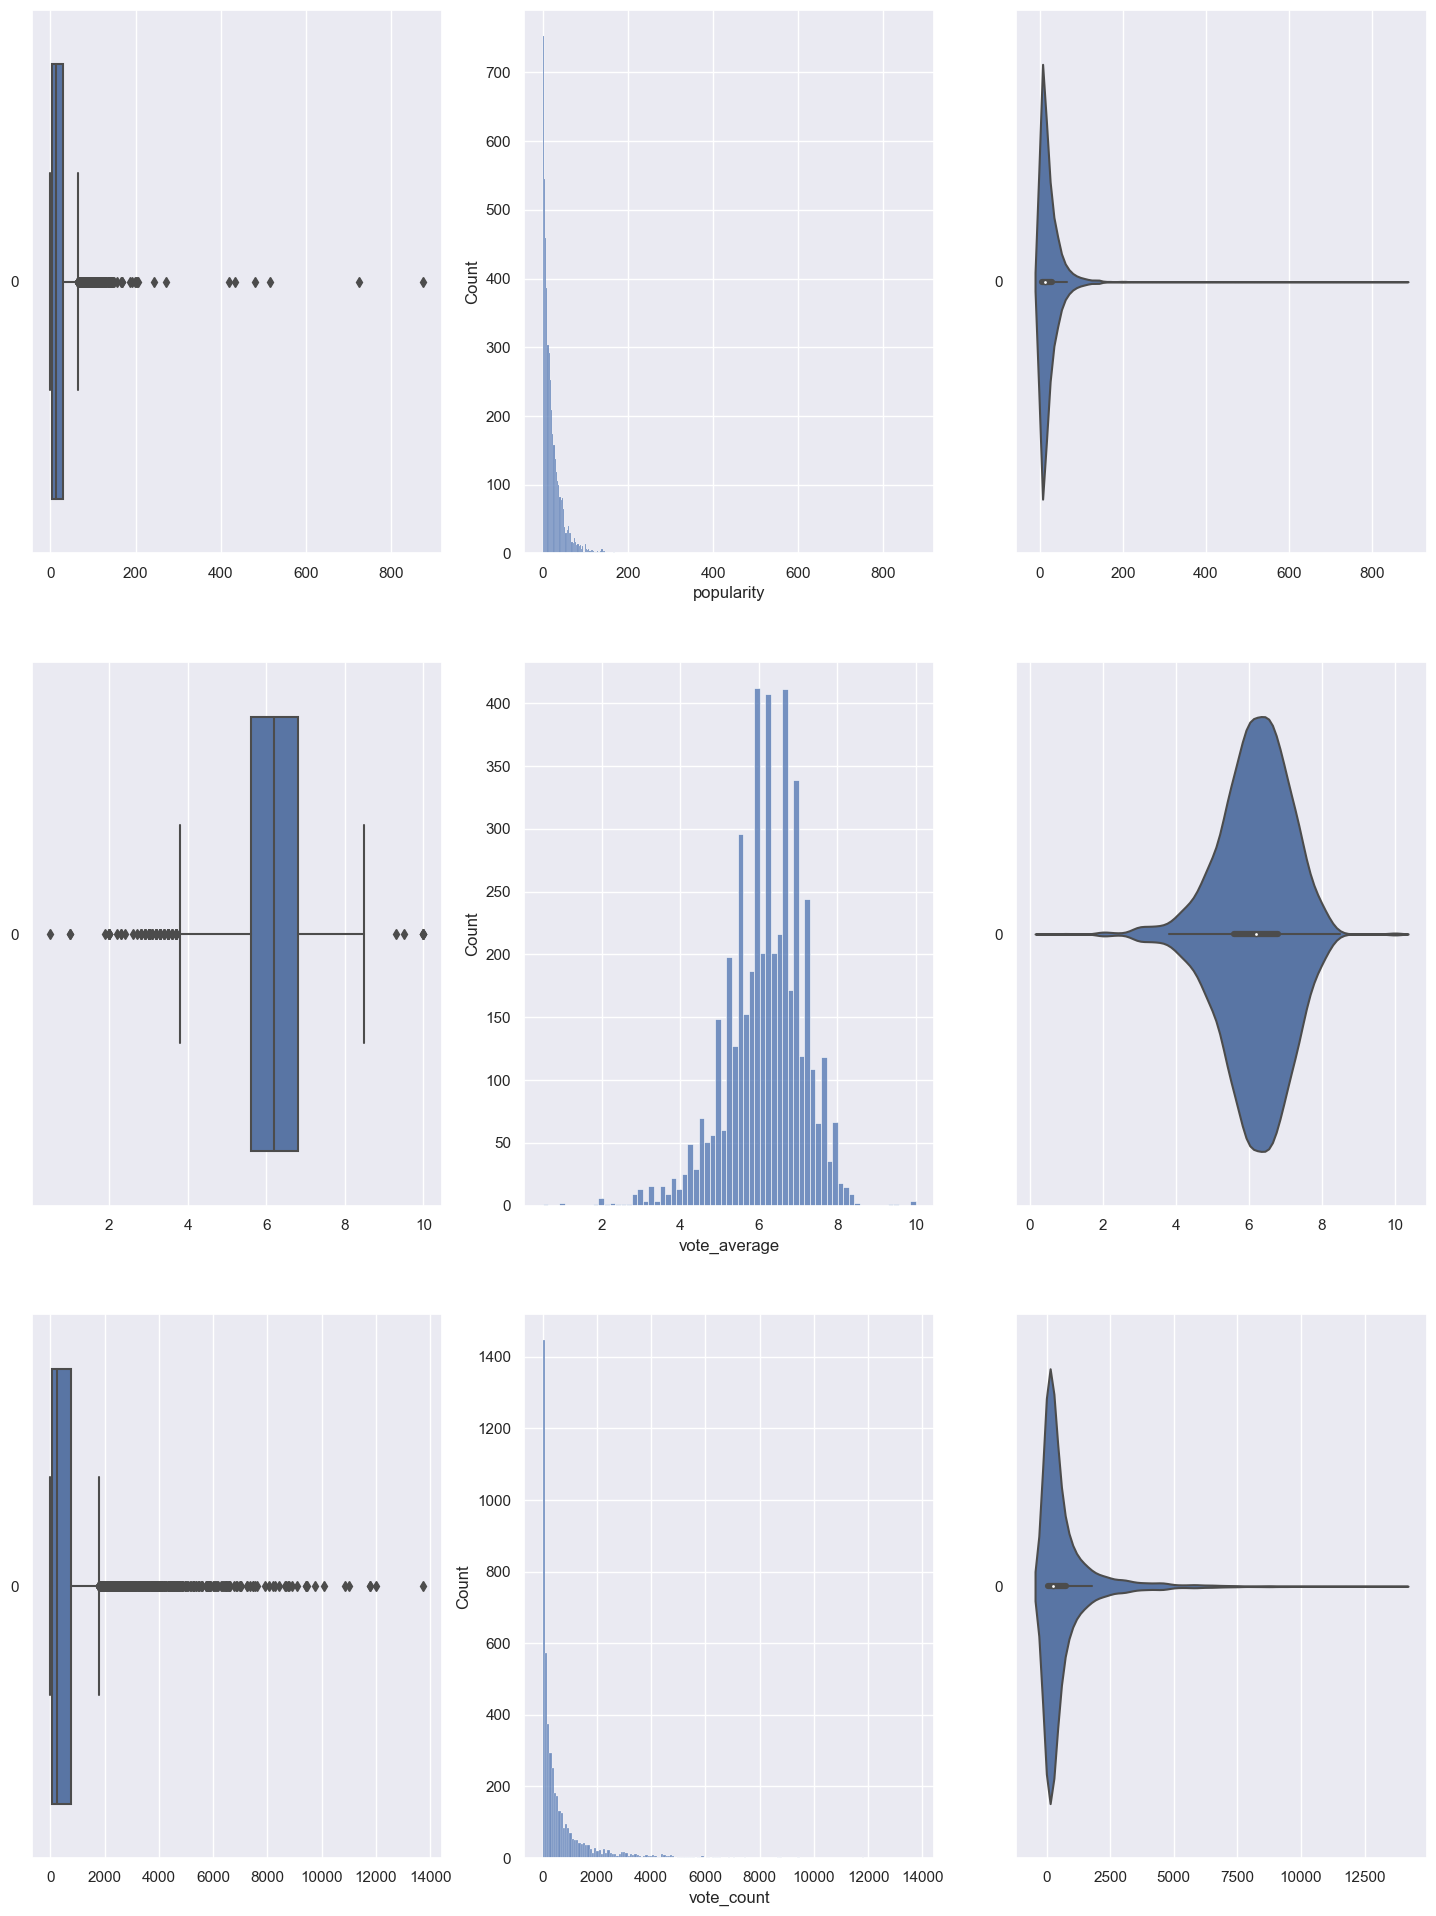

In [24]:
# Draw the distributions of all variables
f, axes = plt.subplots(3, 3, figsize=(18, 24))

count = 0
for var in numeric_data:
    sb.boxplot(data = numeric_data[var], orient = "h", ax = axes[count,0])
    sb.histplot(data = numeric_data[var], ax = axes[count,1])
    sb.violinplot(data = numeric_data[var], orient = "h", ax = axes[count,2])
    count += 1

              popularity  vote_average  vote_count
popularity      1.000000      0.283297    0.777084
vote_average    0.283297      1.000000    0.340810
vote_count      0.777084      0.340810    1.000000


<Axes: >

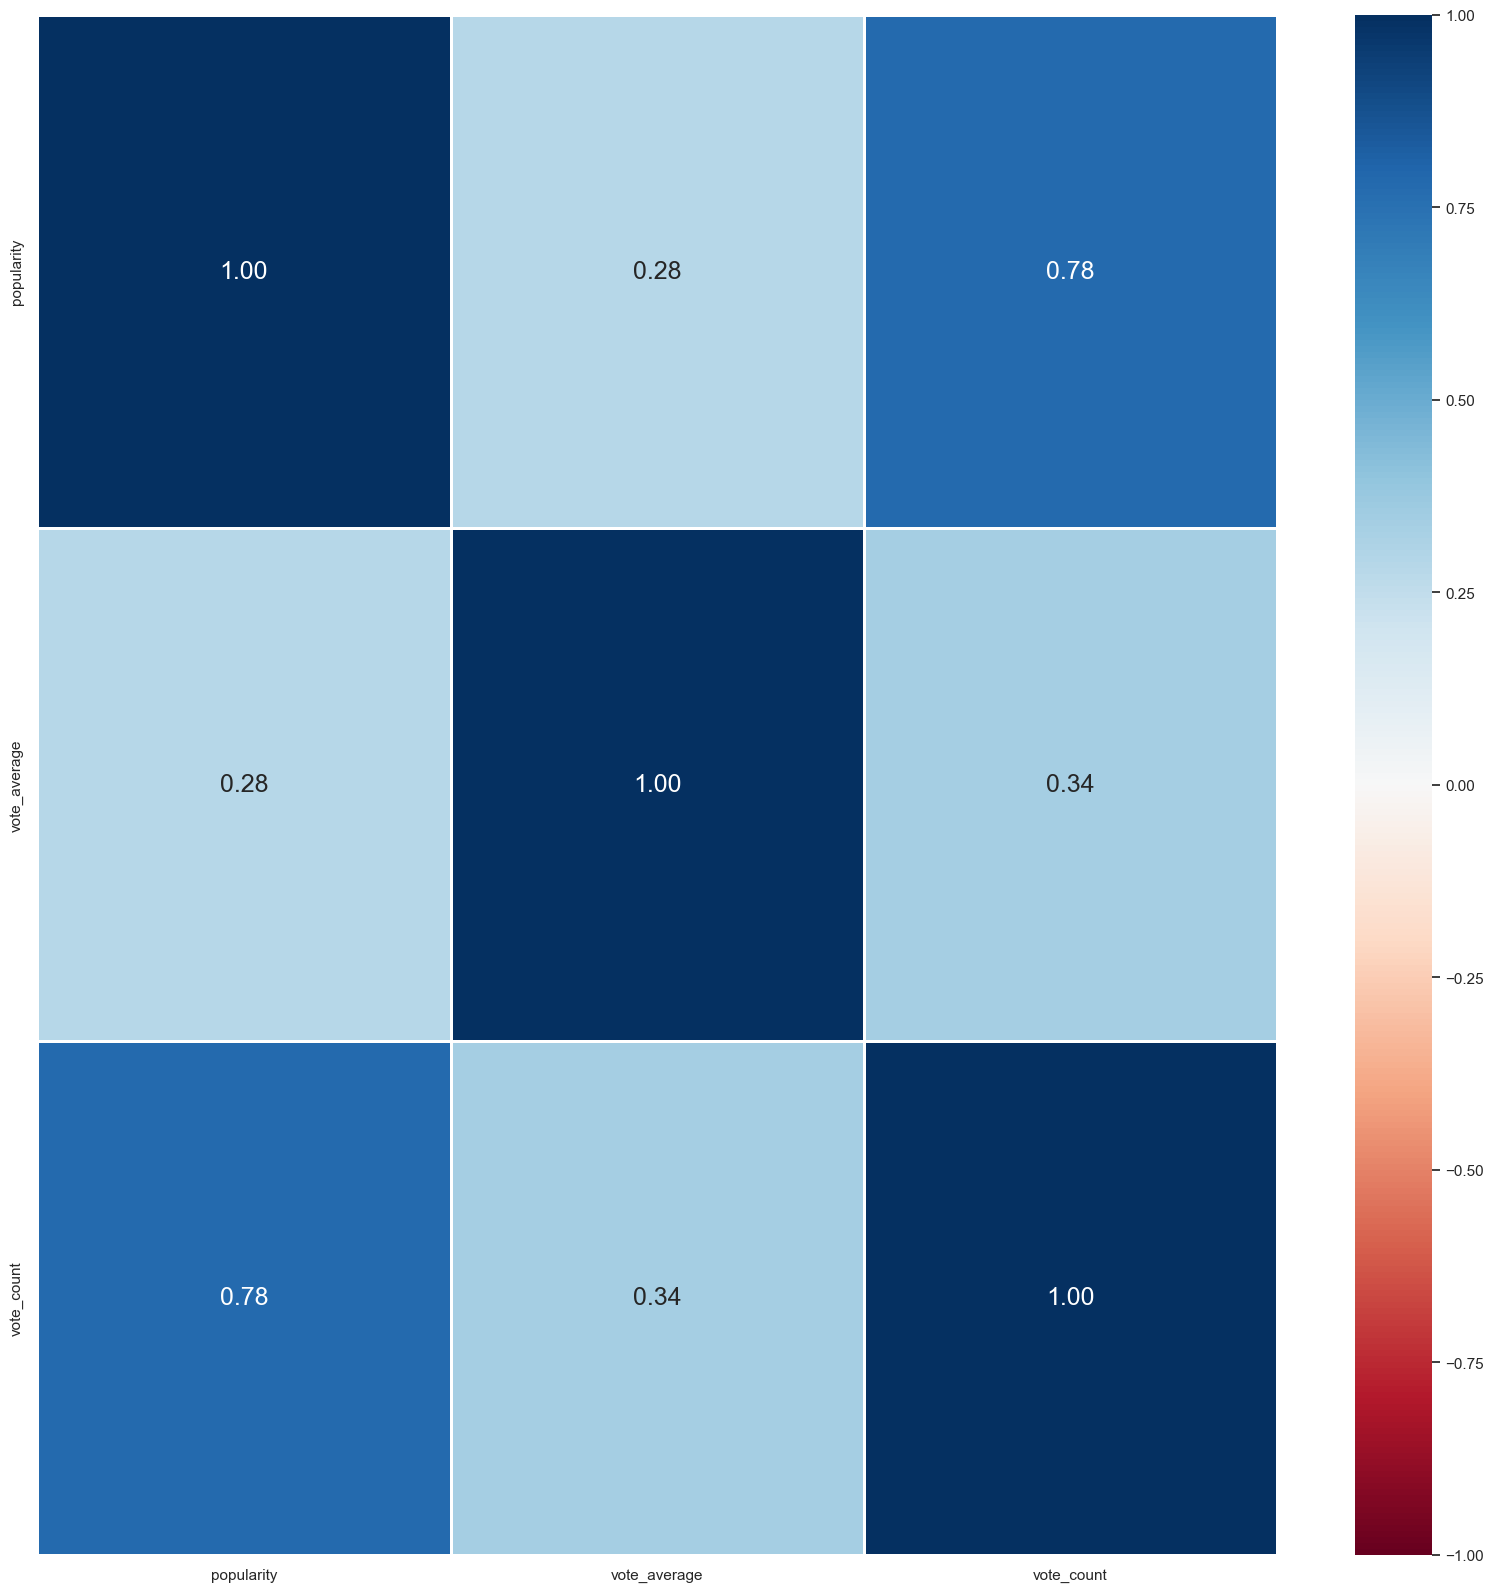

In [25]:
print(numeric_data.corr())

f = plt.figure(figsize=(20, 20))
sb.heatmap(numeric_data.corr(), vmin = -1, vmax = 1, linewidths = 1,
           annot = True, fmt = ".2f", annot_kws = {"size": 18}, cmap = "RdBu")

There is a strong positive correlation between popularity and vote count. This can be inferred that generally a good vote count can be associated to be popular. 

Insight: We could also do popularity based approach recommendation. 

This can serve as a baseline recommendation for users who are not as specific about their preferences or are looking for widely-liked content. Simply sorting movies by their vote counts and recommending the top-rated ones can be effective. 

But this is straightforward, hence we will not be doing this.

List of unique genres: 
Action
Adventure
Fantasy
ScienceFiction
Crime
Drama
Thriller
Animation
Family
Western
Comedy
Romance
Horror
Mystery
History
War
Music
Documentary
Foreign
TVMovie

Unique genres : 20

Action: 1149
Adventure: 790
Fantasy: 424
ScienceFiction: 534
Crime: 691
Drama: 2275
Thriller: 1265
Animation: 234
Family: 510
Western: 79
Comedy: 1709
Romance: 891
Horror: 513
Mystery: 345
History: 197
War: 144
Music: 183
Documentary: 103
Foreign: 34
TVMovie: 8


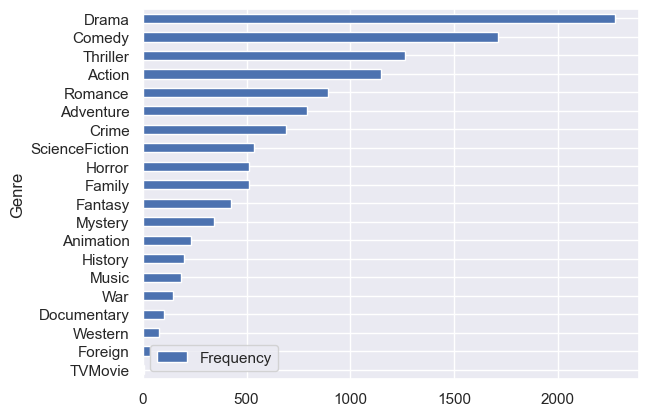

In [26]:
# Frequency of genres for all movies in the dataset:

## numerical (popularity) and categorical (genre)
 
# initialize a null list
unique_list = []

# traverse for all elements
for i in range(0, len(moviesdf["genres"]), 1):
    for x in moviesdf["genres"].iloc[i]:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

print("List of unique genres: ")

# print list
for x in unique_list:
    print(x)

print()

# Names of genres in the Dataset
print("Unique genres :", len(unique_list))
print()

# Initialize an empty dictionary to store the frequencies
value_counts = {}

# Iterate over each row
for row_values in moviesdf["genres"]:
    # Iterate over each value in the row
    for value in row_values:
        # Increment the count for this value in the dictionary
        value_counts[value] = value_counts.get(value, 0) + 1

# Number of films in each genre
for value, count in value_counts.items():
    print(f"{value}: {count}")

# pd.DataFrame([value_counts])
converted = pd.DataFrame.from_dict(value_counts, orient='index', columns=['Frequency'])
converted.reset_index(inplace=True)
converted.columns = ['Genre', 'Frequency']

sort = converted.sort_values('Frequency')

ax = sort.plot.barh(x='Genre', y='Frequency', rot=0)
# sb.catplot(y = "Genre", data = converted, kind = "count", height=6, aspect=2)

In [27]:
moviesdf["primary_genre"].nunique()

20

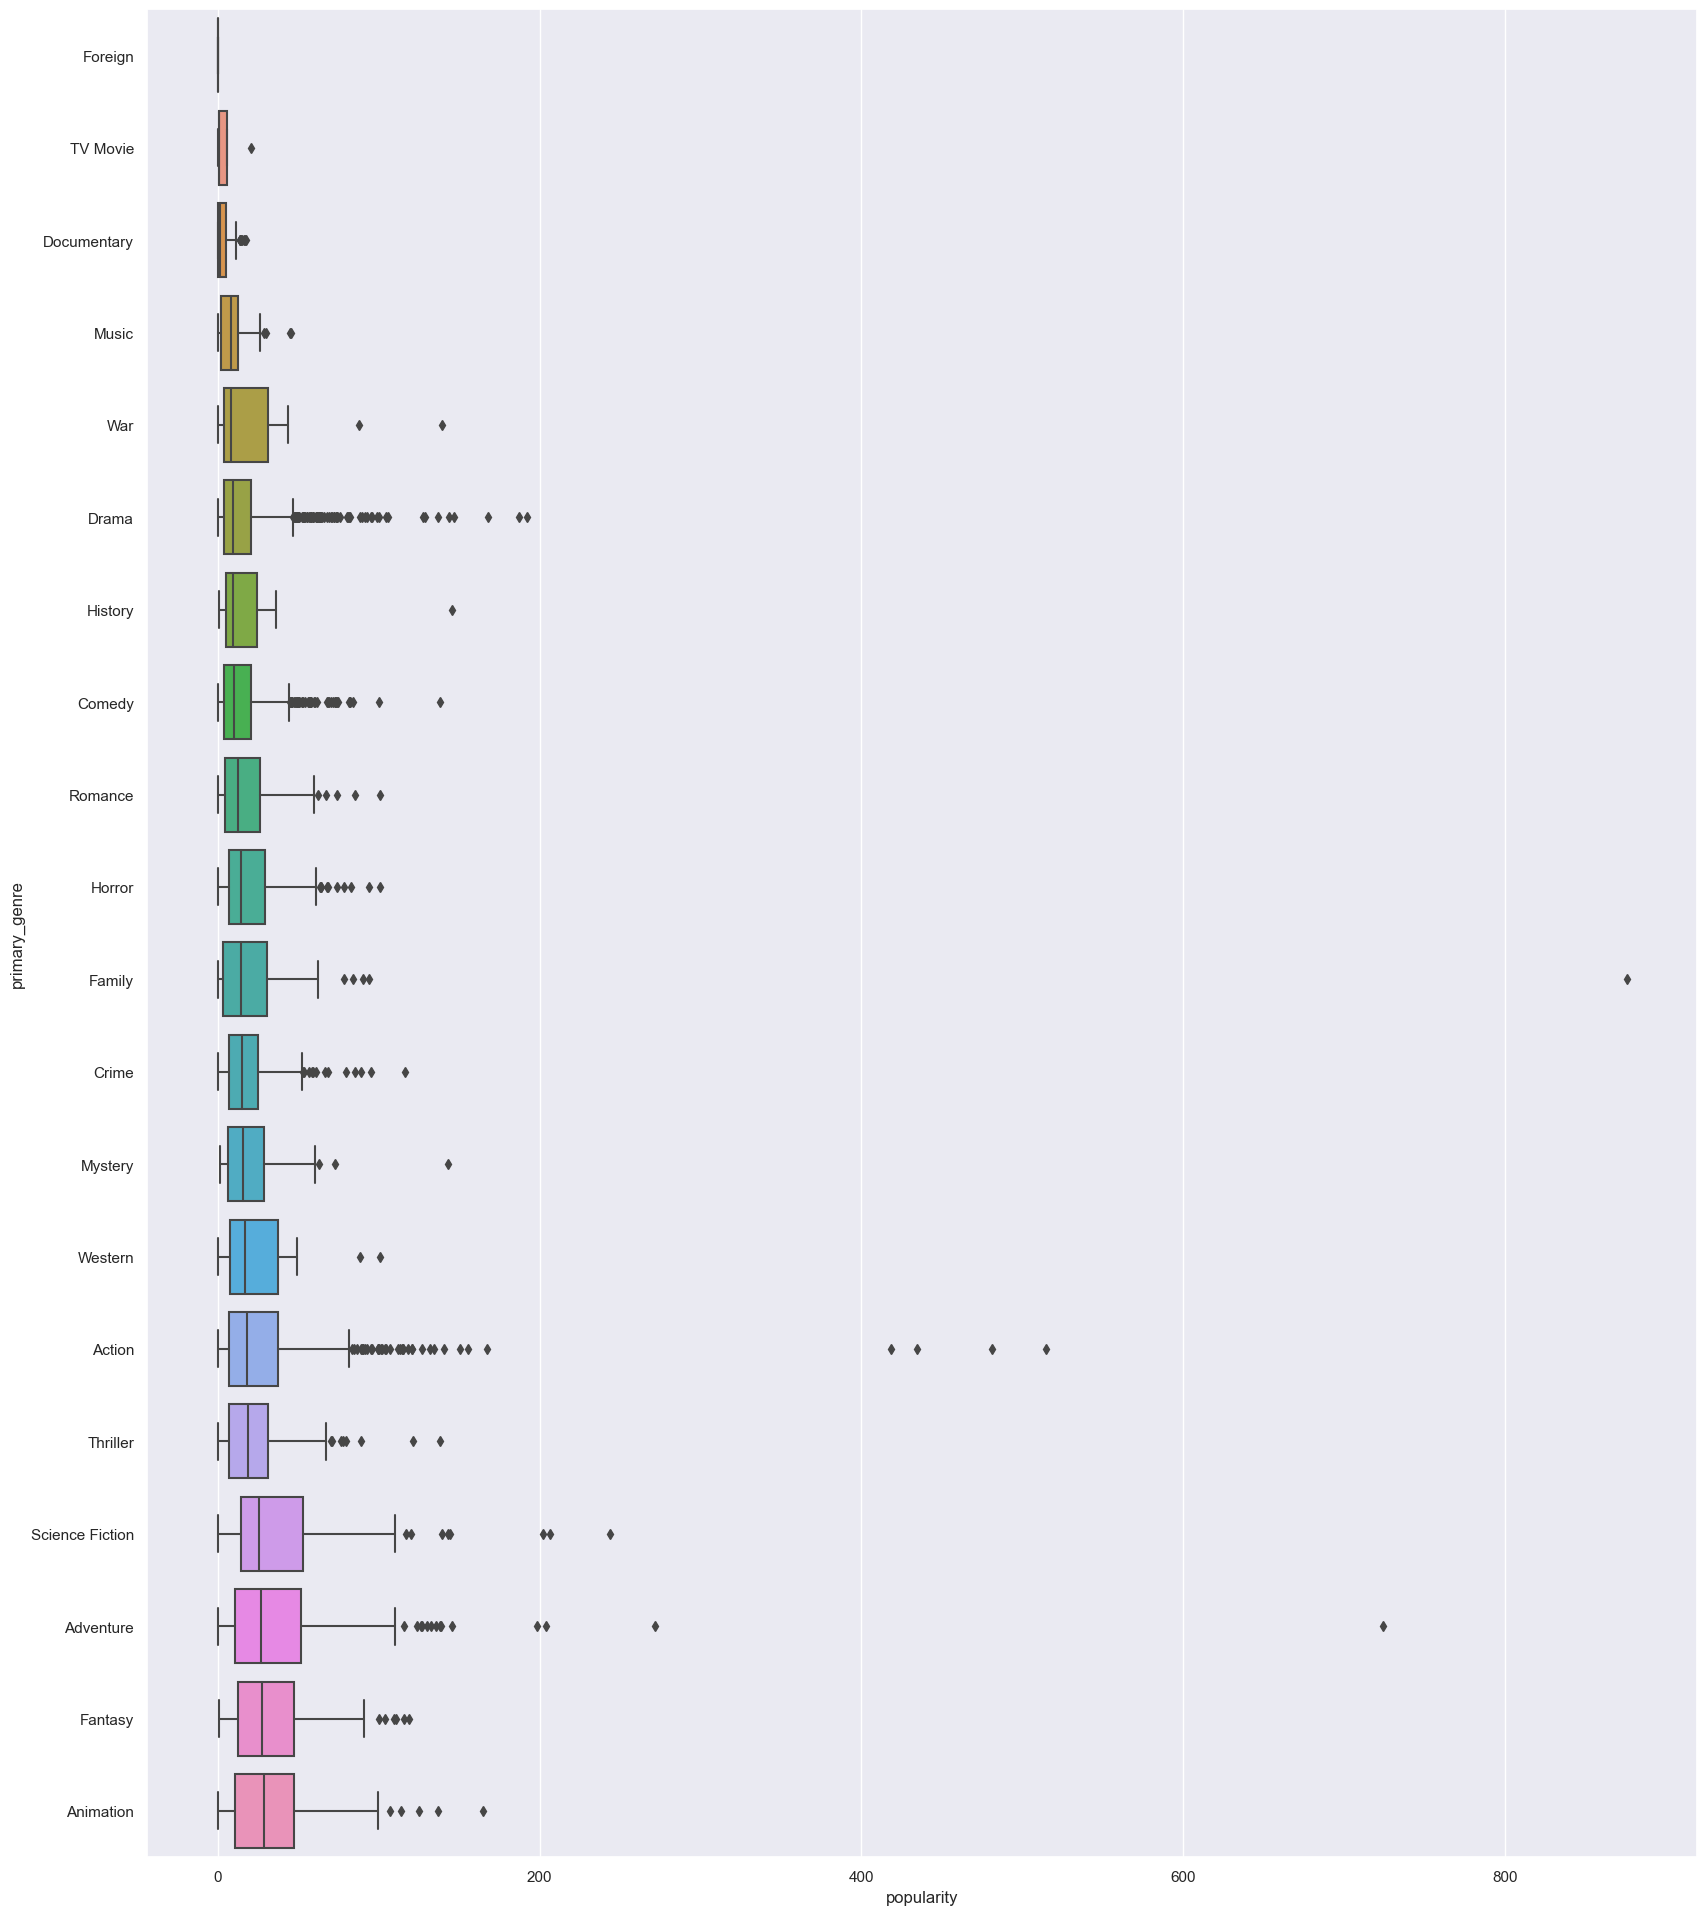

In [28]:
f = plt.figure(figsize=(20, 24))

# Create the boxplot
sb.boxplot(data=moviesdf, x="popularity", y="primary_genre", order=moviesdf.groupby('primary_genre')['popularity'].median().sort_values().index)

# Show the plot
plt.show()

In [29]:
moviesdf["secondary_genre"].nunique()

19

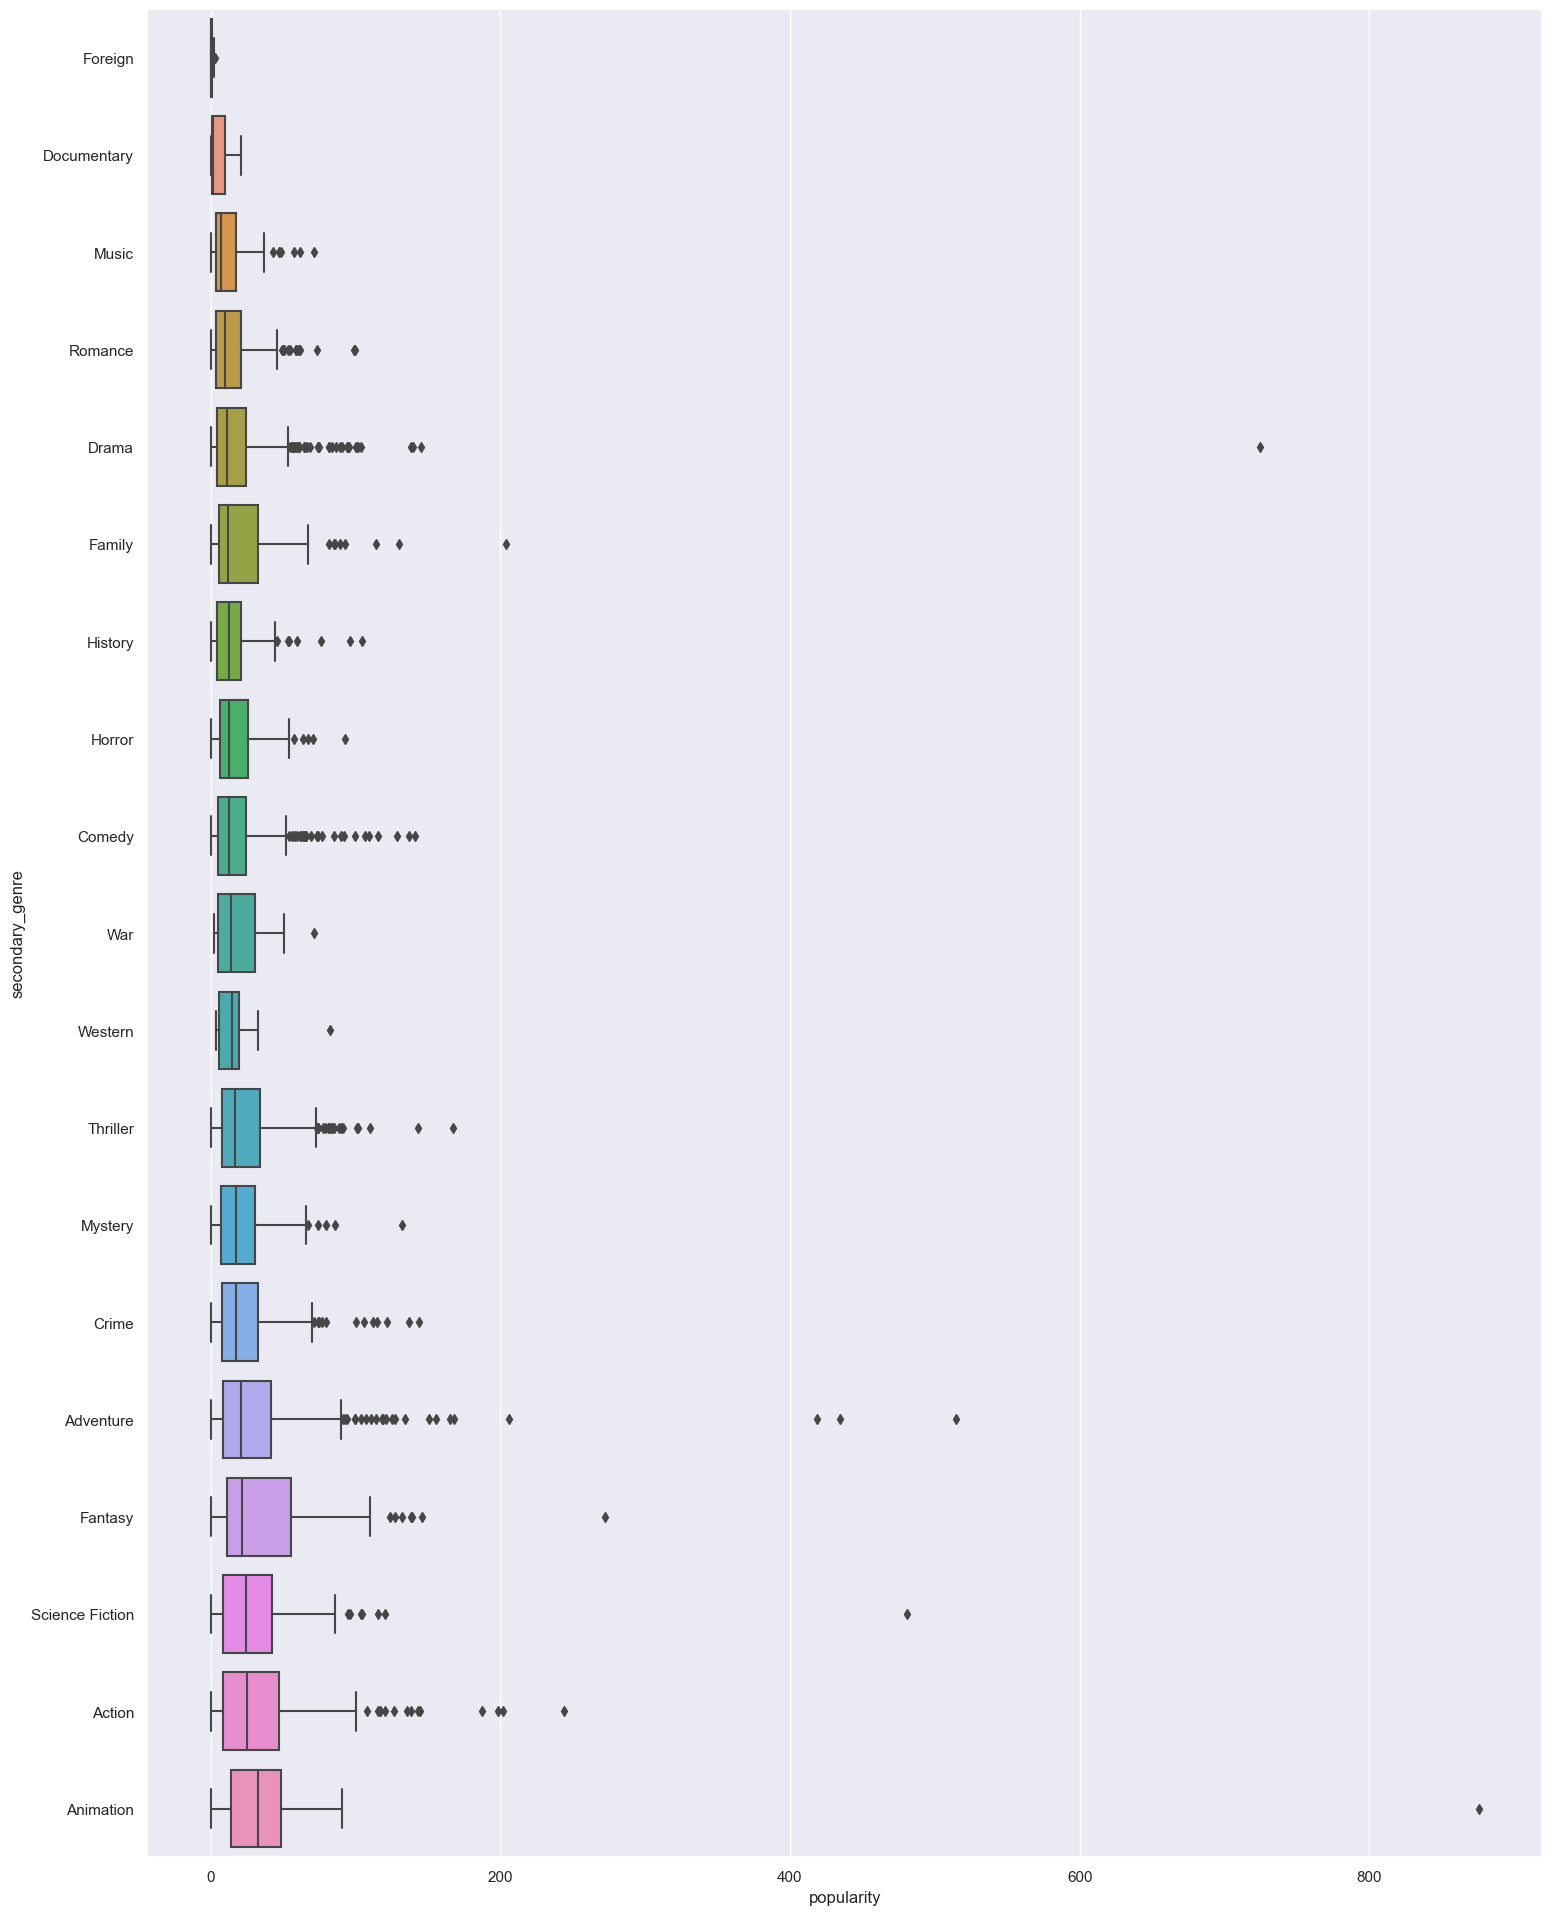

In [30]:
f = plt.figure(figsize=(18, 24))

# Create the boxplot
sb.boxplot(data=moviesdf, x="popularity", y="secondary_genre", order=moviesdf.groupby('secondary_genre')['popularity'].median().sort_values().index)

# Show the plot
plt.show()

For both primary and secondary genre, their boxplots against popularity have much overlap. This could mean that there isn't a clear and distinct relationship between the primary genre of a movie and its popularity. This dataset may have a little difficulty when clustering, albeit genre is an important factor for user preferences. 

This may be a potential data limitation for our project.

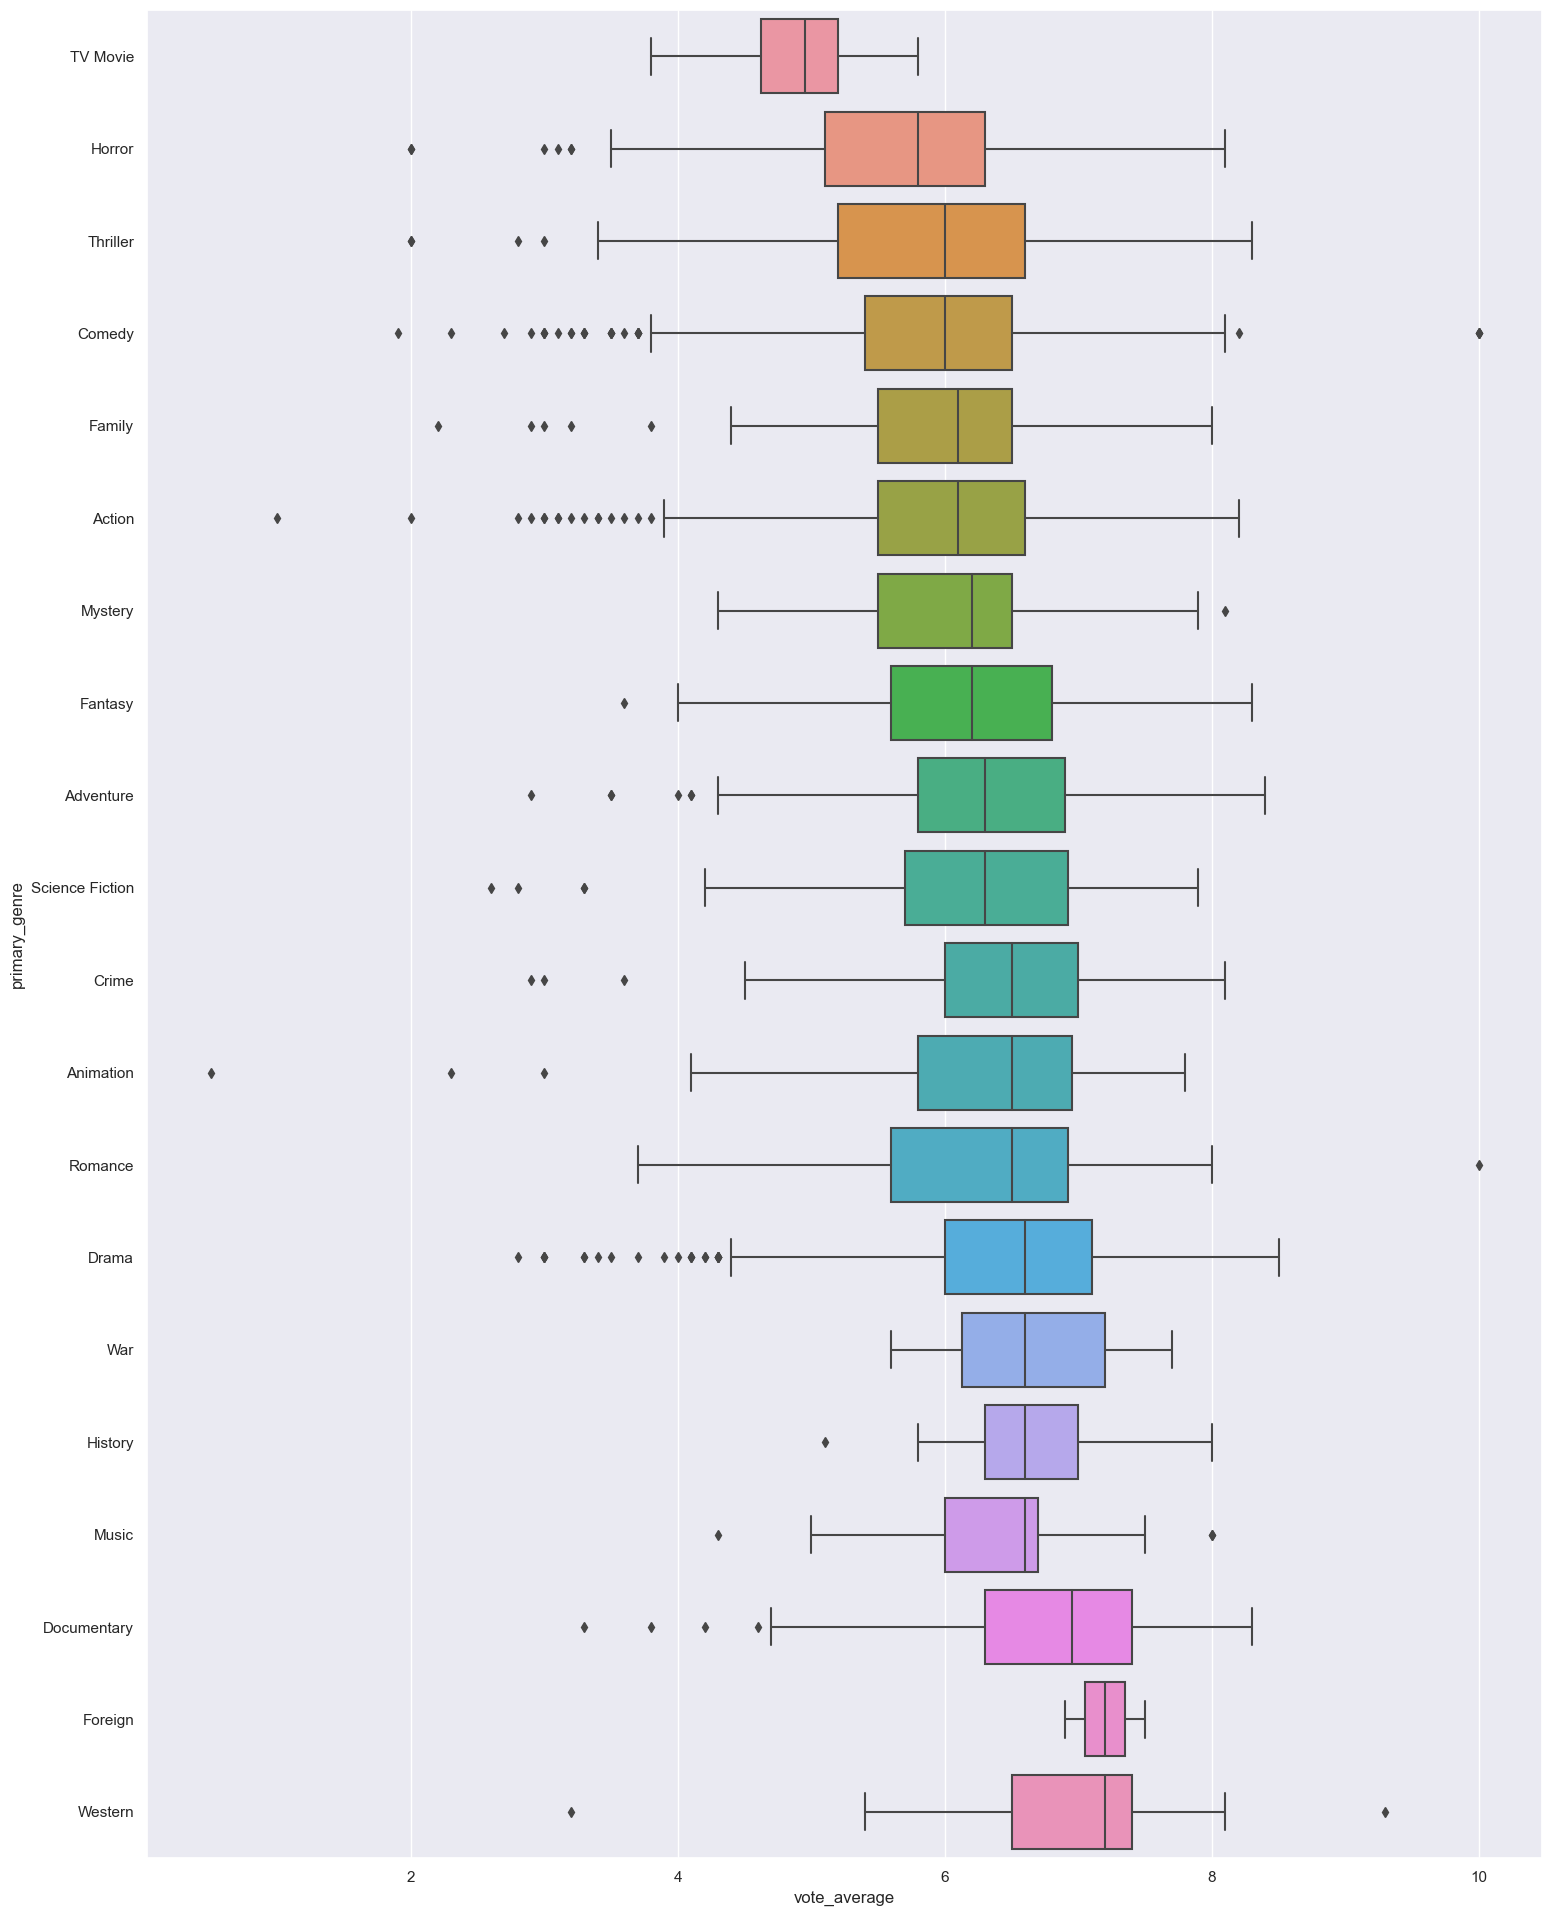

In [31]:
# bar plot of primary genres against vote_average
f = plt.figure(figsize=(18, 24))

# Create the boxplot
sb.boxplot(data=moviesdf, x="vote_average", y="primary_genre", order=moviesdf.groupby('primary_genre')['vote_average'].median().sort_values().index)

# Show the plot
plt.show()

In [32]:
moviesdf["primary_genre"].value_counts()

Drama              1192
Comedy             1037
Action              751
Adventure           339
Horror              297
Crime               194
Thriller            187
Animation           123
Fantasy             117
Romance             104
Science Fiction      96
Documentary          82
Family               54
Mystery              41
Music                33
History              25
Western              25
War                  24
TV Movie              4
Foreign               2
Name: primary_genre, dtype: int64

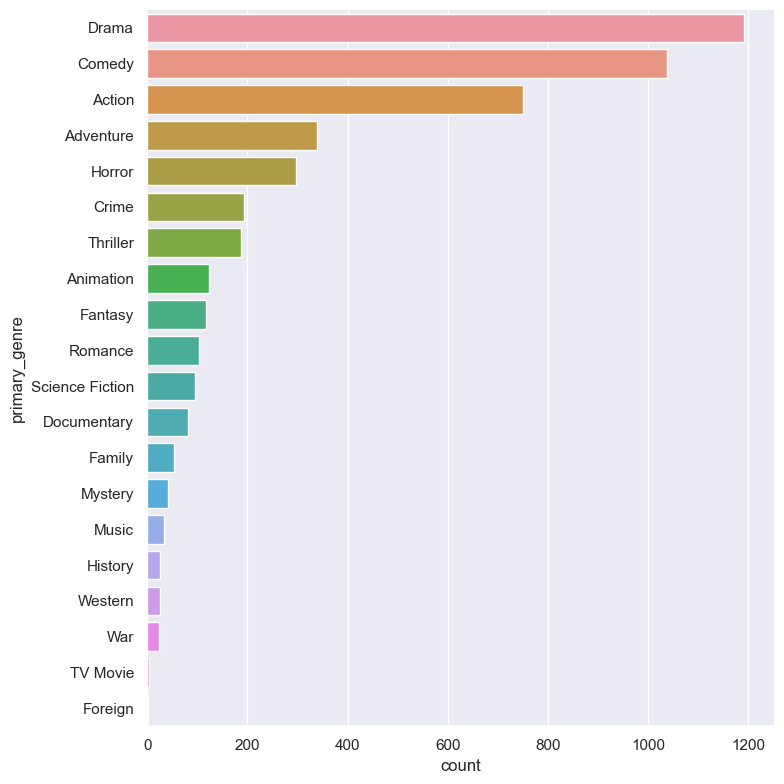

In [33]:
sb.catplot(y = "primary_genre", data = moviesdf , kind = "count", height = 8, order=moviesdf['primary_genre'].value_counts().index)

In [34]:
#Frequency of the most common keywords 
keyword_counts = {}

# Iterate over each row
for row_values in moviesdf["keywords"]:
    # Iterate over each value in the row
    for value in row_values:
        # Increment the count for this value in the dictionary
        keyword_counts[value] = keyword_counts.get(value, 0) + 1

# pd.DataFrame([value_counts])
kconverted = pd.DataFrame.from_dict(keyword_counts, orient='index', columns=['Frequency'])
kconverted.reset_index(inplace=True)
kconverted.columns = ['Keywords', 'Frequency']

sort = kconverted.sort_values('Frequency', ascending=False)

sort.head(50)

,Keywords,Frequency
414,womandirector,318
1879,independentfilm,317
101,duringcreditsstinger,307
38,basedonnovel,197
505,murder,189
36,aftercreditsstinger,170
1156,violence,150
317,dystopia,139
1588,sport,126
89,revenge,118


<function matplotlib.pyplot.show(close=None, block=None)>

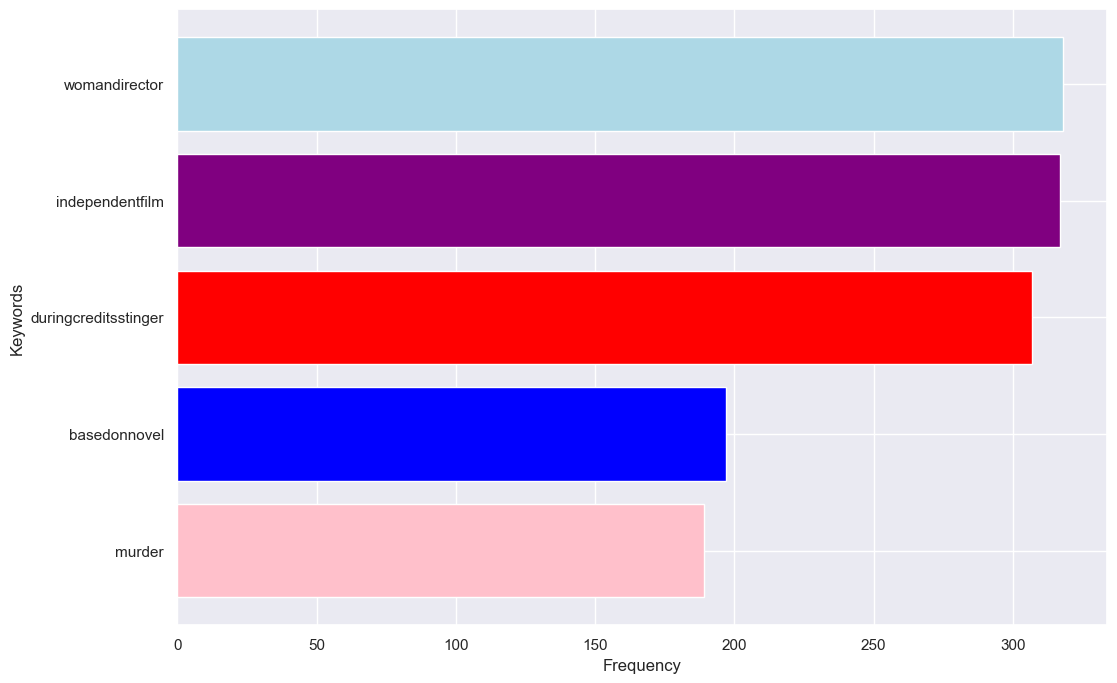

In [35]:
top_keywords = sort.head(5)
plt.figure(figsize=(12,8))
colors = ['lightblue','purple','red','blue','pink']
plt.barh(top_keywords['Keywords'],top_keywords['Frequency'],color = colors)
plt.xlabel('Frequency')
plt.ylabel('Keywords')
plt.gca().invert_yaxis()
plt.show

It can be observed that there are tags such as genres and keywords that appear more frequently across the movies in the dataset. May be useful for our next part.

# Recommendation System 

###  Step 1: Transforming our tags into a numerical  and vector space representation

As previously observed, since there are frequently occuring genres, keywords etc across the movies for our dataset, encoding these features can help capture important characteristics of each movie. 

So we will first group these keywords under 'tags'.

In [36]:
moviesdf['tags'] = moviesdf['genres'] + moviesdf['keywords'] + moviesdf['cast'] + moviesdf['crew']

/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/1731722409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['tags'] = moviesdf['genres'] + moviesdf['keywords'] + moviesdf['cast'] + moviesdf['crew']


In [37]:
moviesdf['tags'] = moviesdf['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/4160109026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['tags'] = moviesdf['tags'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


In [38]:
moviesdf.head()

,genres,id,keywords,popularity,tagline,title,vote_average,vote_count,movie_id,cast,crew,primary_genre,secondary_genre,tags
0,"[Action, Adventure, Fantasy, ScienceFiction]",19995,"[cultureclash, future, spacewar, spacecolony, ...",150.437577,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[SamWorthington, ZoeSaldana, SigourneyWeaver, ...",[JamesCameron],Action,Adventure,Action Adventure Fantasy ScienceFiction cultur...
1,"[Adventure, Fantasy, Action]",285,"[ocean, drugabuse, exoticisland, eastindiatrad...",139.082615,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[JohnnyDepp, OrlandoBloom, KeiraKnightley, Ste...",[GoreVerbinski],Adventure,Fantasy,Adventure Fantasy Action ocean drugabuse exoti...
2,"[Action, Adventure, Crime]",206647,"[spy, basedonnovel, secretagent, sequel, mi6, ...",107.376788,A Plan No One Escapes,Spectre,6.3,4466,206647,"[DanielCraig, ChristophWaltz, LéaSeydoux, Ralp...",[SamMendes],Action,Adventure,Action Adventure Crime spy basedonnovel secret...
3,"[Action, Crime, Drama, Thriller]",49026,"[dccomics, crimefighter, terrorist, secretiden...",112.312950,The Legend Ends,The Dark Knight Rises,7.6,9106,49026,"[ChristianBale, MichaelCaine, GaryOldman, Anne...",[ChristopherNolan],Action,Crime,Action Crime Drama Thriller dccomics crimefigh...
4,"[Action, Adventure, ScienceFiction]",49529,"[basedonnovel, mars, medallion, spacetravel, p...",43.926995,"Lost in our world, found in another.",John Carter,6.1,2124,49529,"[TaylorKitsch, LynnCollins, SamanthaMorton, Wi...",[AndrewStanton],Action,Adventure,Action Adventure ScienceFiction basedonnovel m...


For our recommendation system, we will be using mainly Kmeans and cosine similarity. However in order to do so, we need to represent these categorical variables as numerical datas.

Using TfidVectorizer(), we represent each movies in a vector space where each dimension corresponds to a genre, keyword, crew(director), cast(lead actors) in order to use techniques like cosine similarity or clustering (in the later part) to find similar movies or group them based on their shared/common attributes.

In [39]:
vectorizer = TfidfVectorizer()

In [40]:
tags_vector = vectorizer.fit_transform(moviesdf['tags'])

### 1) Content-based filtering using cosine similarity

In [41]:
tags_similarity = cosine_similarity(tags_vector)

In [42]:
find_similarmovie = input('Key in the movie that you want us to recommend from: ')

Key in the movie that you want us to recommend from: Avatar


In [43]:
# This function gets the vector representation for a specific movie based on tags
# Compares it to the rest of the movies the in dataset
# Take the first 10 movies that have the highest similarity score to specified movie as recommendations

def movierecommendation(find_similarmovie):
    movie_index = moviesdf[moviesdf['title'] == find_similarmovie].index[0]
    similarity_score = list(enumerate(tags_similarity[movie_index]))
    sorted_similarity_score = sorted(similarity_score, key = lambda x:x[1], reverse = True)
    recommended_movies = sorted_similarity_score[1:11]
    recommended_movie_titles = [moviesdf.iloc[movie[0]]['title'] for movie in recommended_movies]
    return recommended_movie_titles
        

In [44]:
print("Movies similar to", find_similarmovie)
movierecommendation(find_similarmovie)

Movies similar to Avatar


['Star Trek Into Darkness',
 'Aliens',
 'Alien³',
 'Predators',
 'The Nut Job',
 "Ender's Game",
 'Guardians of the Galaxy',
 'Planet of the Apes',
 'A Monster in Paris',
 'Jupiter Ascending']

### 2) Hybrid method clustering

For this method, we will utilize both the user's preference and content of movies in order to give the optimal recommendation. 

We begin by be using KMeans clustering for our movie dataset, but before we do so, we need to find the optimal number of clusters.

### Find optimal number of clusters

Elbow method: Works by finding WCSS (Within-Cluster Sum of Square) i.e. the sum of the square distance between points in a cluster and the cluster centroid.

Aim: to identify the “elbow” point, where the rate of variance decreases sharply levels off, suggesting an appropriate cluster count for analysis or model training.

In [45]:
wcss = [] 
for i in range(1, 30): 
    kmeans = KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeans.fit(tags_vector) 
    wcss.append(kmeans.inertia_)

/Users/sxppy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/sxppy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


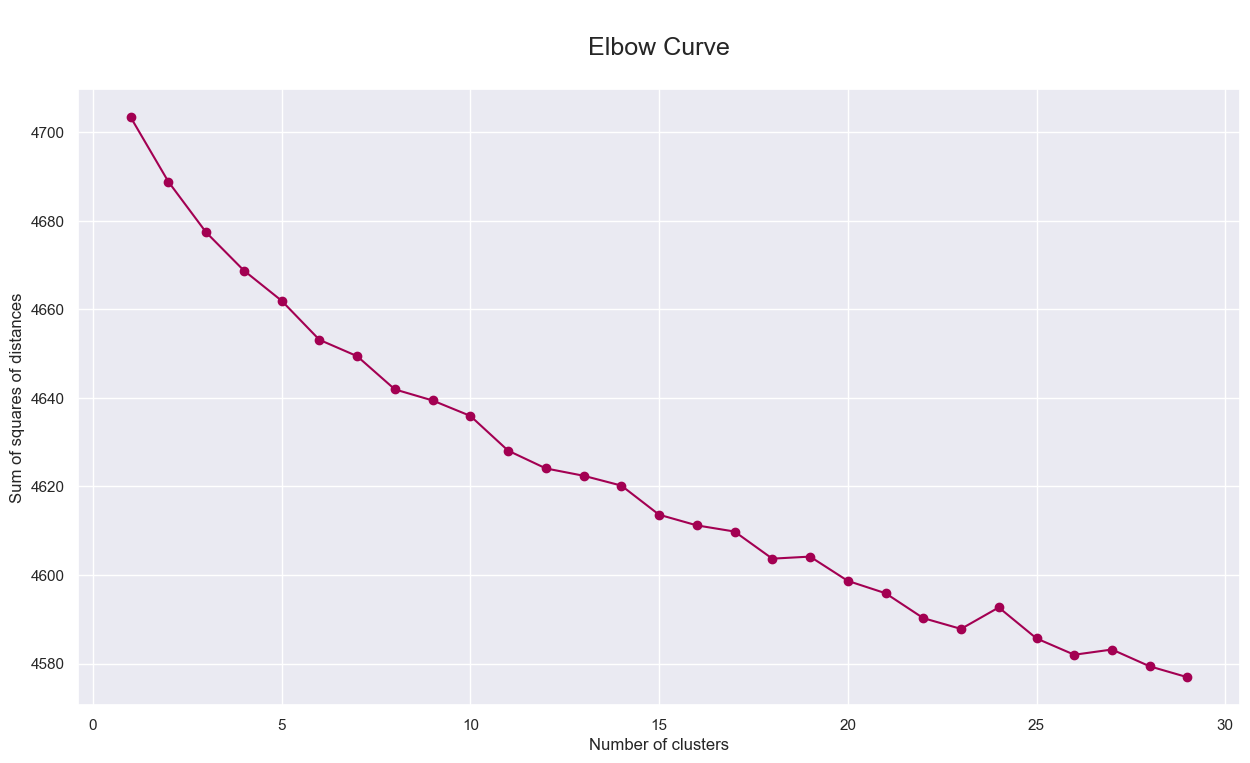

In [46]:
plt.figure(figsize=(15,8))
plt.plot(range(1, 30), wcss, marker='o', color='#a30052')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares of distances')
plt.title('\nElbow Curve\n', fontsize=18)
plt.show()

Since there is no clear 'elbow point' we will try another method

Silhouette Method: Way to measure each data point’s similarity to the cluster it belongs to and how different it is from other clusters. 

Aim: The higher the value, the better. 

In [47]:
sil_score = []
for i in range(2,30):
    kmeans = KMeans(n_clusters = i, random_state = 42, n_init=10)
    sil_score.append(silhouette_score(tags_vector, kmeans.fit_predict(tags_vector)))

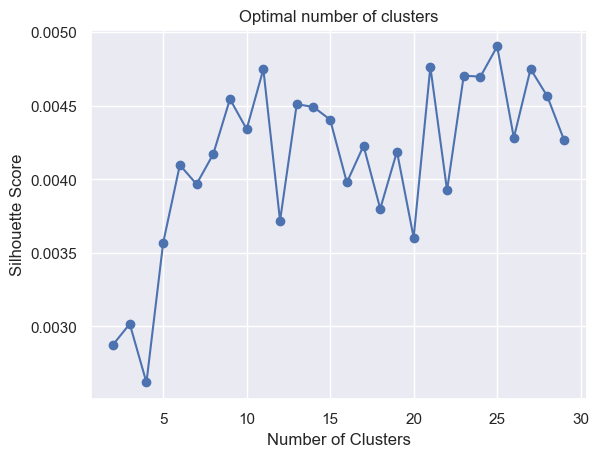

In [48]:
plt.plot(range(2, 30), sil_score, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Optimal number of clusters')
plt.show()

In [49]:
# cluster movies into 25 clusters because silhouette score is highest around there
num_clusters = 25

# Principle Component Analysis

We reduce the dimensionality of our data from 4 to 2 for visualisation.

In [50]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA(2)
pca_result = pca.fit_transform(tags_vector.toarray())
result = pd.DataFrame(data=pca.fit_transform(tags_vector.toarray()), columns = ['Feature 1', 'Feature 2'])
result.head()

,Feature 1,Feature 2
0,-0.054505,0.117099
1,-0.034352,0.092608
2,-0.097889,0.042879
3,-0.093911,-0.020570
4,-0.076308,0.104044


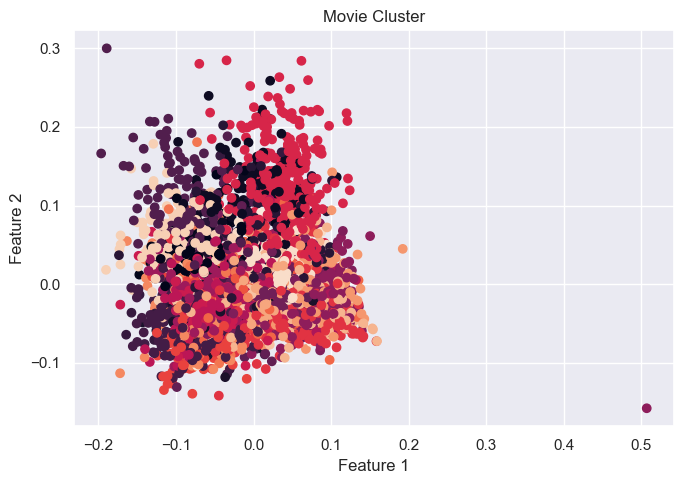

In [52]:
plt.figure(figsize=(7,5))
 
# Scatter plot
plt.scatter(result['Feature 1'],result['Feature 2'],c=kmeans.labels_)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Movie Cluster')
plt.tight_layout()

# Cluster the movies

In [53]:
#n_clusters = num_clusters is the number of clusters --> each cluster represents a group of movies that share similar features
#random_state: sets random seed for intialisation, ensures reproducibility of results
kmeans_movies = KMeans(n_clusters = num_clusters, random_state = 42)
print(kmeans_movies)

#creates an array of cluster labels predicted for each movie
cluster_labels = kmeans_movies.fit_predict(tags_vector)

KMeans(n_clusters=25, random_state=42)


/Users/sxppy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [54]:
# dimension of vector
print(tags_vector.shape)

(4740, 21590)


In [55]:
#add movie cluster labels
moviesdf['cluster'] = cluster_labels

/var/folders/cr/ync1dlkx1kj096wnjnfw20t40000gn/T/ipykernel_18435/1572823963.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moviesdf['cluster'] = cluster_labels


In [56]:
#cluster centers
cluster_centers = kmeans_movies.cluster_centers_
print("Cluster centers shape", cluster_centers)

Cluster centers shape [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [57]:
moviesdf.head(2)

,genres,id,keywords,popularity,tagline,title,vote_average,vote_count,movie_id,cast,crew,primary_genre,secondary_genre,tags,cluster
0,"[Action, Adventure, Fantasy, ScienceFiction]",19995,"[cultureclash, future, spacewar, spacecolony, ...",150.437577,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[SamWorthington, ZoeSaldana, SigourneyWeaver, ...",[JamesCameron],Action,Adventure,Action Adventure Fantasy ScienceFiction cultur...,17
1,"[Adventure, Fantasy, Action]",285,"[ocean, drugabuse, exoticisland, eastindiatrad...",139.082615,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[JohnnyDepp, OrlandoBloom, KeiraKnightley, Ste...",[GoreVerbinski],Adventure,Fantasy,Adventure Fantasy Action ocean drugabuse exoti...,17


In [58]:
moviesdf["cluster"].value_counts()

19    564
6     520
21    418
15    389
22    386
0     332
17    271
10    220
1     218
5     161
7     152
16    119
12    113
11    109
24    102
9      98
8      93
20     76
3      74
18     73
14     70
2      62
13     45
23     44
4      31
Name: cluster, dtype: int64

## Generate user data

We do not have a user data set for the movie. Hence, for the purpose of illustrating the hybrid approach, we will be generating our own user data. 

We will set a specific genre preference randomly for 10 users. Generate 6/10 watched movies ids with that genre as the primary genre and rate them highly, Remaining 4/10 movies will be randomly generated and rated. 

Limitations: May not be able to accurately represent real-world movies preferences of individuals. 



In [59]:
import random
np.random.seed(42)
user_data = []

#10 user samples
for user_id in range(1,11):
    unique_genres = moviesdf['primary_genre'].unique()
    
    # randomly pick a preferred primary genre to mimic real life preference
    random_genre = random.choice(unique_genres)
    
    # pick another genre if the num of movies for that genre is less than 6
    # otherwise there might be a value error
    while len(moviesdf[moviesdf['primary_genre'] == random_genre]) < 6:
        random_genre = random.choice(unique_genres)
    
    # get movies from that preferred genre
    randomgenre_movies = moviesdf[moviesdf['primary_genre'] == random_genre]
    
    # randomly choose 6 movies from that preferred genre
    interested_movies = np.random.choice(randomgenre_movies.id, size = 6, replace = False)
    
    # select 4 other movies randomly
    # ensure no repetition of what is already in the watched list
    remaining_movies = moviesdf[~moviesdf['id'].isin(interested_movies)]
    watched_movies = np.random.choice(remaining_movies.id, size = 4, replace = False)
    
    #generate rating from 1-5 for each movie
    for movie_id in watched_movies:
        rating = np.random.choice([0,1,2,3,4,5])
        user_data.append({'user_id': user_id, 'movie_id': movie_id, 'movie_name': moviesdf.loc[moviesdf['id'] == movie_id, 'title'].values[0], 'rating': rating, 'cluster_num': moviesdf.loc[moviesdf['id'] == movie_id, 'cluster'].values[0]})
        
    for movie_id in interested_movies:
        rating = np.random.choice([3,4,5])
        user_data.append({'user_id': user_id, 'movie_id': movie_id, 'movie_name': moviesdf.loc[moviesdf['id'] == movie_id, 'title'].values[0], 'rating': rating, 'cluster_num': moviesdf.loc[moviesdf['id'] == movie_id, 'cluster'].values[0]})
        
    user_datadf = pd.DataFrame(user_data)

In [60]:
user_datadf.head(11)

,user_id,movie_id,movie_name,rating,cluster_num
0,1,4824,The Jackal,3,4
1,1,115,The Big Lebowski,0,15
2,1,177,The Fisher King,0,19
3,1,756,Fantasia,1,21
4,1,60463,Sunday School Musical,4,9
5,1,8328,Step Up 2: The Streets,3,6
6,1,17820,Show Boat,5,6
7,1,14024,Raise Your Voice,4,9
8,1,525,The Blues Brothers,5,15
9,1,8872,Wayne's World,4,15


## Model users' preferences

We model the user preference by calculating the ratings for each cluster that their watched movies belong to. This shows that they have a speciifc preference towards a certain cluster belonging to the dataset.

In [61]:
#create dictionary of users preference (in the form of accumulated ratings)
user_pref = {}
for user_id in range(1,11): 
    # create columns
    user_cluster_pref = np.zeros(cluster_centers.shape[1])
    # list of movies watched by the user
    user_movies = user_datadf[user_datadf['user_id'] == user_id]['movie_id']
    # for every movie
    for movie_id in user_movies:
        cluster = moviesdf.loc[moviesdf['id'] == movie_id, 'cluster'].values[0]
        rating = user_datadf[(user_datadf['user_id'] == user_id) & (user_datadf['movie_id'] == movie_id)]['rating'].values[0]
        user_cluster_pref[cluster] += rating
    user_pref[user_id] = user_cluster_pref

### Use cosine similarity to recommend 3 movies based on user preference and clusters formed in dataset

In [62]:
#import cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [63]:
def recommend_movies(user_id, cluster_centers, num_rec = 3):
    #get users pref
    user_cluster_pref = user_pref[user_id]
    
    #compute similarity between movie and user cluster
    user_cluster_pref_expand = np.expand_dims(user_cluster_pref, axis = 0)
    similarities = cosine_similarity(user_cluster_pref_expand, cluster_centers)
    
    #get id of movies recommended
    top_movieID = similarities.argsort()[0][-num_rec:]
    
    #get movies recommended
    rec_movies = []
    #prevent recommendation of watched movies
    watched_movies = set(user_datadf[user_datadf['user_id'] == user_id]['movie_id'])
    for i in top_movieID:
        movies_in_cluster = moviesdf[(moviesdf['cluster'] == i) & (~moviesdf['id'].isin(watched_movies))]
        rec_movie = movies_in_cluster.sample(1)['title'].values[0]
        rec_movies.append(rec_movie)
    
    return rec_movies

In [64]:
for user_id in range(1,11):
    recommendations = recommend_movies(user_id, cluster_centers)
    print("Recommended movies for user", user_id, ": ")
    for i, movie in enumerate(recommendations, start = 1):
        print(i, ".", movie)

Recommended movies for user 1 : 
1 . Death Sentence
2 . Alice Through the Looking Glass
3 . The Visitors
Recommended movies for user 2 : 
1 . Street Fighter: The Legend of Chun-Li
2 . Jingle All the Way
3 . Spider-Man 2
Recommended movies for user 3 : 
1 . Seven Years in Tibet
2 . Red Planet
3 . The Host
Recommended movies for user 4 : 
1 . The Hobbit: An Unexpected Journey
2 . Spider-Man 3
3 . Shrek Forever After
Recommended movies for user 5 : 
1 . Sense and Sensibility
2 . Tin Cup
3 . It's All Gone Pete Tong
Recommended movies for user 6 : 
1 . The Diary of a Teenage Girl
2 . Money Train
3 . About Time
Recommended movies for user 7 : 
1 . We Are Marshall
2 . The Wedding Planner
3 . The Queen
Recommended movies for user 8 : 
1 . Men in Black 3
2 . Due Date
3 . To Die For
Recommended movies for user 9 : 
1 . I Spy
2 . Dragon Hunters
3 . Iron Man 2
Recommended movies for user 10 : 
1 . August
2 . 12 Angry Men
3 . Batman: The Dark Knight Returns, Part 2


# Analysis of recommendation system

Since our user data is small and randomly generated ourselves, it will be difficult to evaluate the accuracy of our recommendation. 

As an improvement, we would look into getting a large user sample data for these movies in order to check the recall rate of a movie title that a user watches in the future according to the recommendations given.

# References

https://www.kaggle.com/code/tanusreedas/simple-recommender-system-step-by-step-explained

https://www.kaggle.com/code/olyapotemkina/movie-recommendation-system-dbscan